In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.layers import Lambda

def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [4]:
def train_and_evaluate_gru_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features
    # features = ['Timesteps [- / 5 minutes]', 'Action Ventilation', 'Action Toplights', 'Action Heater',
    #             f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    features = ['Timesteps [- / 5 minutes]', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], -1, 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], -1, 1))

    if flag_train:
        # Define the input shapes
        time_steps = X_train_scaled.shape[1]

        # Inputs
        input_q_physics = Input(shape=(time_steps, 1), name='input_q_physics')
        input_q_nn = Input(shape=(time_steps, 1), name='input_q_nn')

        # Concatenate the features
        input_features = Concatenate()([input_q_physics, input_q_nn])

        # GRU Layer to process the time series data
        gru_output = GRU(units=64, return_sequences=False)(input_features)

        # Dense layers to predict w_physics and w_nn
        w_physics = Dense(1, activation='linear', name='w_physics')(gru_output)
        w_nn = Dense(1, activation='linear', name='w_nn')(gru_output)

        # y_hat calculation based on the predicted weights
        # q_physics_flatten = tf.squeeze(input_q_physics, axis=-1)
        # q_nn_flatten = tf.squeeze(input_q_nn, axis=-1)
        # y_hat = tf.reduce_sum(q_physics_flatten * w_physics + q_nn_flatten * w_nn, axis=-1)
        # Flatten the inputs
        q_physics_flatten = Lambda(lambda x: tf.squeeze(x, axis=-1))(input_q_physics)
        q_nn_flatten = Lambda(lambda x: tf.squeeze(x, axis=-1))(input_q_nn)

        # y_hat calculation based on the predicted weights using Lambda layers
        y_hat = Lambda(lambda x: tf.reduce_sum(x[0] * x[1] + x[2] * x[3], axis=-1))([q_physics_flatten, w_physics, q_nn_flatten, w_nn])

        # Define the model
        model = Model(inputs=[input_q_physics, input_q_nn], outputs=y_hat)

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Train the model
        history = model.fit([X_train_scaled, X_train_scaled], y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save the model and scaler
        model.save(f'gru-models/{target_variable}_gru_model.keras')
        joblib.dump(scaler, f'gru-models/{target_variable}_gru_scaler.pkl')

        y_hat_test = model.predict([X_test_scaled, X_test_scaled])
    else:
        # Load the model and scaler
        loaded_model = load_model(f'gru-models/{target_variable}_gru_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        scaler = joblib.load(f'gru-models/{target_variable}_gru_scaler.pkl')

        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], -1, 1))

        y_hat_test = loaded_model.predict([X_test_scaled, X_test_scaled])

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 437.8594 - mae: 20.5547 - r2_score_metric: -11433.4434 - val_loss: 352.7866 - val_mae: 17.7788 - val_r2_score_metric: -9846.5625
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 326.5490 - mae: 16.6980 - r2_score_metric: -8449.0010 - val_loss: 330.0836 - val_mae: 17.0398 - val_r2_score_metric: -9346.6025
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 296.8880 - mae: 15.7055 - r2_score_metric: -7292.0854 - val_loss: 288.6991 - val_mae: 15.5295 - val_r2_score_metric: -8412.1084
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 252.3658 - mae: 14.0621 - r2_score_metric: -6379.7998 - val_loss: 246.8991 - val_mae: 13.5960 - val_r2_score_metric: -7463.7285
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 218.1051 - mae: 12.3149 - r2_score_metric: -5897.1621 - val_loss: 218.3154 - val_mae: 12.0163 - val_r2_score_metric: -6892.8403
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

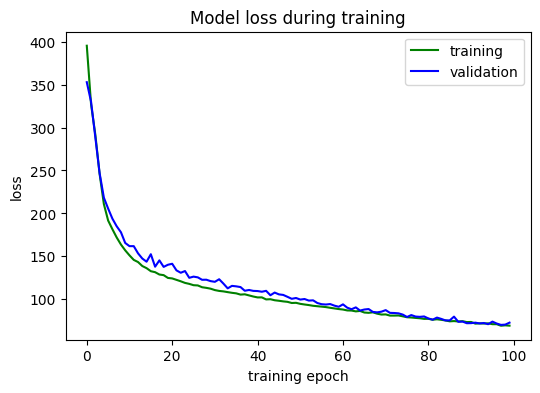

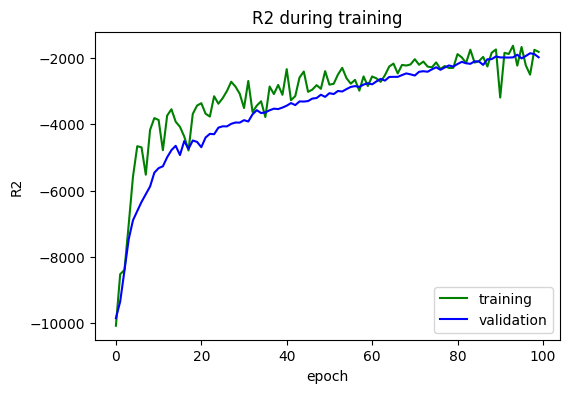

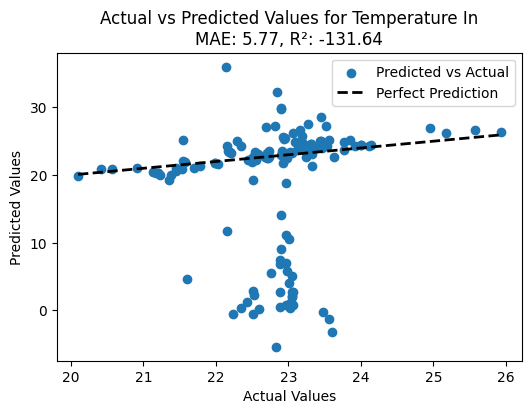

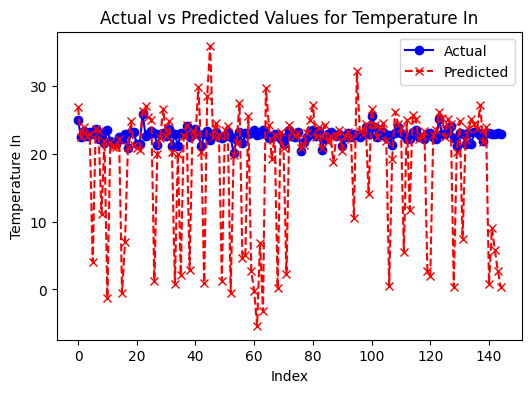

In [5]:
train_and_evaluate_gru_model(target_variable='Temperature In', flag_train=True)